<a href="https://colab.research.google.com/github/bchuchucaa/RNNConsumoDeAgua/blob/main/RNNConsumoDeAgua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/archive.zip

unzip:  cannot find or open /content/archive.zip, /content/archive.zip.zip or /content/archive.zip.ZIP.


In [1]:
from pandas import read_csv
from datetime import datetime
import pandas as pd
from matplotlib import pyplot
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import model_from_json
from sklearn.metrics import mean_squared_error
from keras.layers import Dense,Activation,Flatten

print('LIBRERIAS IMPORTADAS')

LIBRERIAS IMPORTADAS


**LECTURA DE DATOS**

In [35]:
#LOADING DATA 
df= read_csv('/content/AguaH.csv')
df = df.iloc[0:50 , :]
#AJUSTE DEL FORMATO DE LAS FECHAS 
lookup = {'ENE':'01','FEB':'02','MAR':'03','ABR':'04','MAY':'05','JUN':'06','JUL':'07','AGO':'08','SEP':'09','OCT':'10','NOV':'11','DIC':'12'}
clist=[]
for col in df.columns[5:]:
    col = col[4:].split('_')
    clist.append('20'+col[1]+'-'+lookup[col[0]]+'-01')

columns = ['LANDUSE_TYPE','USER','PIPE DIAM','VENDOR','JAN16']+clist
df.columns=columns
df = df.drop(columns=['LANDUSE_TYPE','PIPE DIAM','VENDOR','JAN16'])

#df=df.transpose()
print("Dataframe shape ",df.shape)


Dataframe shape  (50, 85)


In [3]:
df.head()

,USER,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,2009-12-01,2010-01-01,2010-02-01,2010-03-01,2010-04-01,2010-05-01,2010-06-01,2010-07-01,2010-08-01,2010-09-01,2010-10-01,2010-11-01,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01,2012-01-01,2012-02-01,2012-03-01,...,2012-09-01,2012-10-01,2012-11-01,2012-12-01,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2015-01-01,2015-02-01,2015-03-01,2015-04-01,2015-05-01,2015-06-01,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01,2015-12-01
0,DOMESTICO MEDIO,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,24.0,24.0,24.0,24.0,1.0,17.0,0.0,14.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,7.0,7.0,42.0,27.0,22.0,21.0
1,DOMESTICO MEDIO,NaN,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,...,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,29.0,29.0,29.0,0.0,11.0,20.0,19.0,0.0,16.0,10.0,12.0,12.0,11.0,0.0,8.0,11.0,13.0,16.0,14.0,15.0,16.0,13.0,17.0,17.0,11.0
2,DOMESTICO RESIDENCIAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,20.0,16.0,12.0,11.0,9.0,9.0,7.0,11.0,7.0,11.0,8.0,6.0,9.0,7.0,8.0,8.0,10.0,12.0,9.0,6.0,3.0
3,DOMESTICO MEDIO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,4.0,34.0,18.0,9.0,24.0,20.0,15.0,7.0,8.0,8.0,7.0,11.0,10.0,...,17.0,13.0,13.0,13.0,2.0,13.0,11.0,0.0,8.0,7.0,6.0,54.0,20.0,12.0,9.0,17.0,5.0,19.0,0.0,13.0,9.0,9.0,49.0,30.0,23.0,21.0,23.0,25.0,0.0,13.0,17.0,20.0,16.0,16.0,18.0,18.0,17.0,17.0,18.0,9.0
4,DOMESTICO RESIDENCIAL,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,23.0,23.0,0.0,72.0,27.0,27.0,42.0,30.0,0.0,31.0,27.0,27.0,27.0,28.0,28.0,31.0,27.0,27.0,27.0,24.0


In [36]:
#ESTE CODIGO SIRVE UNICAMENTE PARA LA INTEGRACION DE LOS NOMBRES EN EL DATAFRAME
col_list = ["Name"]
names = pd.read_csv("/content/StateNames.csv", usecols=col_list)
names = names.iloc[0:50 , :]
#ELIMINAMOS LA COLUMNA DE LOS NOMBRE YA QUE SE BINARIZARON
#df = df.iloc[: , 1:]
print("Names shape ",names.shape)
df.insert(loc=1, column='Names', value=names)

Names shape  (50, 1)


In [37]:
#AJUSTE DEL DATASET EN EL FORMATO SOLICITADO 
rows_list=[]
dataComp = pd.DataFrame(columns=('DATE','NOMBRE','TIPO', 'CONSUMO'))
for column in range(2,len(df.columns),1):
  selection=df.iloc[:,column]
  for row in range(len(selection)):
    df2=[df.columns[column],df.iloc[row,1],df.iloc[row,0],selection.iloc[row]]
    rows_list.append(df2)
    
dataComp = pd.DataFrame(rows_list)  

In [6]:
dataComp.head()

,0,1,2,3
0,2009-01-01,Mary,DOMESTICO MEDIO,20.0
1,2009-01-01,Annie,DOMESTICO MEDIO,NaN
2,2009-01-01,Anna,DOMESTICO RESIDENCIAL,NaN
3,2009-01-01,Margaret,DOMESTICO MEDIO,NaN
4,2009-01-01,Helen,DOMESTICO RESIDENCIAL,20.0


In [38]:
dataComp.rename(columns = {0:'DATE',1:'NOMBRE',2:'TIPO',3:'CONSUMO'}, inplace = True)
dataComp['DATE'] = pd.to_datetime(dataComp['DATE'], format='%Y-%m-%d')
dataComp=dataComp.set_index('DATE')
#RANGO DE FECHAS DE LAS MUESTRAS
print(dataComp.index.min())
print(dataComp.index.max())

2009-01-01 00:00:00
2015-12-01 00:00:00


In [ ]:
#CANTIDAD DE MUESTRAS POR ANIO
print(len(dataComp['2009']))
print(len(dataComp['2010']))
print(len(dataComp['2011']))
print(len(dataComp['2012']))
print(len(dataComp['2013']))
print(len(dataComp['2014']))
print(len(dataComp['2015']))

600
600
600
600
600
600
600


In [9]:
#DESCRIPCION DEL DATASET
dataComp.describe()

,CONSUMO
count,3367.000000
mean,15.453222
std,9.010332
min,0.000000
25%,10.000000
50%,15.000000
75%,20.000000
max,88.000000


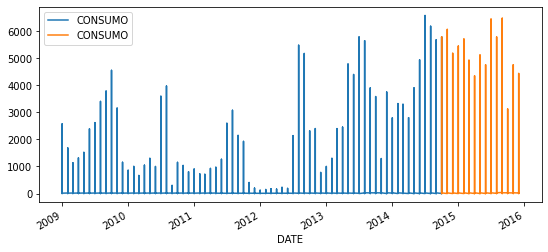

In [ ]:
import matplotlib.pyplot as plt
steps = 14400
datos_train = dataComp[:-steps]
datos_test  = dataComp[-steps:]
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend();

In [39]:
#RELLENANDO VALORES NAN POR LA MEDIA
dataComp=dataComp.fillna(dataComp['CONSUMO'].mean())
#CONVIRTIENDO EL INDICE DEL DATAFRAME EN TIPO DATETIME
#dataComp.index = pd.to_datetime(dataComp.index)
#type(dataComp.index)

In [ ]:
dataComp.head()

,NOMBRE,TIPO,CONSUMO
DATE,,,
2009-01-01,Mary,DOMESTICO MEDIO,20.00000
2009-01-01,Annie,DOMESTICO MEDIO,94.57314
2009-01-01,Anna,DOMESTICO RESIDENCIAL,94.57314
2009-01-01,Margaret,DOMESTICO MEDIO,94.57314
2009-01-01,Helen,DOMESTICO RESIDENCIAL,20.00000


In [40]:
salida= dataComp.iloc[:,2]
dataComp = dataComp.drop('CONSUMO',axis = 1)
dataComp.head()

,NOMBRE,TIPO
DATE,,
2009-01-01,Mary,DOMESTICO MEDIO
2009-01-01,Annie,DOMESTICO MEDIO
2009-01-01,Anna,DOMESTICO RESIDENCIAL
2009-01-01,Margaret,DOMESTICO MEDIO
2009-01-01,Helen,DOMESTICO RESIDENCIAL


In [41]:
# Create a categorical boolean mask
categorical_feature_mask = dataComp.dtypes == object
# Filter out the categorical columns into a list for easy reference later on in case you have more than a couple categorical columns
categorical_cols = dataComp.columns[categorical_feature_mask].tolist()

# Instantiate the OneHotEncoder Object
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)


In [42]:
dataComp['TIPO'] = dataComp['TIPO'].astype(str)
dataComp['NOMBRE'] = dataComp['NOMBRE'].astype(str)

In [43]:
# Apply ohe on data
ohe.fit(dataComp[categorical_cols])
cat_ohe = ohe.transform(dataComp[categorical_cols])

#Create a Pandas DataFrame of the hot encoded column
ohe_df = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names(input_features = categorical_cols))
#concat with original data and drop original columns


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [44]:
df_ohe = pd.concat([dataComp, ohe_df], axis=1).drop(columns = categorical_cols, axis=1)


ValueError: ignored

In [48]:
ohe_df.head()

,NOMBRE_Agnes,NOMBRE_Alice,NOMBRE_Anna,NOMBRE_Annie,NOMBRE_Clara,NOMBRE_Dorothy,NOMBRE_Elizabeth,NOMBRE_Elsie,NOMBRE_Esther,NOMBRE_Ethel,NOMBRE_Frances,NOMBRE_Helen,NOMBRE_Jean,NOMBRE_Julia,NOMBRE_Lillian,NOMBRE_Louise,NOMBRE_Lucy,NOMBRE_Margaret,NOMBRE_Marie,NOMBRE_Martha,NOMBRE_Mary,NOMBRE_Mildred,NOMBRE_Pauline,NOMBRE_Ruth,TIPO_DOMESTICO BAJA,TIPO_DOMESTICO MEDIO,TIPO_DOMESTICO RESIDENCIAL,TIPO_SOCIAL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [45]:
#PCA Projection to 2D
from sklearn.decomposition import PCA
num_components=5
pca = PCA(num_components)
principalComponents = pca.fit_transform(ohe_df)
a = range(num_components)
num_pc= a[::1]

principalDf = pd.DataFrame(data = principalComponents
             , columns = num_pc)

principalDf=round(principalDf, 2)
print(principalDf)

         0     1     2     3     4
0    -0.65  0.01 -0.28  0.82 -0.17
1    -0.54 -0.00  0.04 -0.13  0.63
2     0.85 -0.22  0.03  0.10  0.16
3    -0.54 -0.28 -0.61 -0.47 -0.44
4     0.76 -0.33  0.78  0.03 -0.42
...    ...   ...   ...   ...   ...
4195  0.81 -0.19  0.02  0.07  0.11
4196 -0.63 -0.12 -0.02 -0.05  0.10
4197  0.16  1.09  0.05 -0.19 -0.16
4198 -0.63 -0.12 -0.02 -0.05  0.10
4199 -0.63 -0.12 -0.02 -0.05  0.10

[4200 rows x 5 columns]


In [20]:
principalDf.index= salida.index

In [21]:

principalDf.insert(loc=5, column='CONSUMO', value=salida)

In [22]:
principalDf.rename(columns = {0:'PC1',1:'PC2',2:'PC3',3:'PC4',4:'PC5'}, inplace = True)

principalDf.head()

,PC1,PC2,PC3,PC4,PC5,CONSUMO
DATE,,,,,,
2009-01-01,-0.65,0.01,-0.28,0.82,-0.17,20.000000
2009-01-01,-0.54,-0.00,0.04,-0.13,0.63,15.453222
2009-01-01,0.85,-0.22,0.03,0.10,0.16,15.453222
2009-01-01,-0.54,-0.28,-0.61,-0.47,-0.44,15.453222
2009-01-01,0.76,-0.33,0.78,0.03,-0.42,20.000000


In [28]:
#PROMEDIO MENSUAL DE CONSUMO DE AGUA
meses = dataComp.resample('M').mean()
meses

DataError: ignored

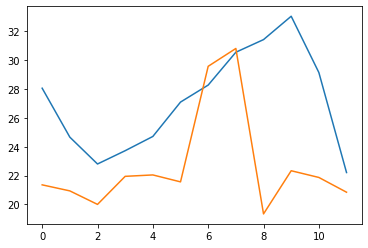

In [ ]:
plt.plot(meses['2009'].values)
plt.plot(meses['2010'].values)

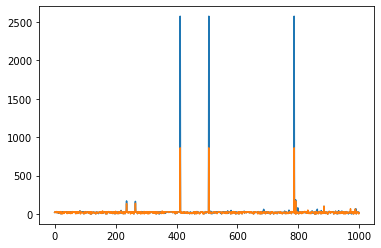

In [ ]:
verano2009 = dataComp['2009-01-01':'2009-01-31']
plt.plot(verano2009.values)
verano2010 = dataComp['2010-01-01':'2010-01-31']
plt.plot(verano2010.values)

In [23]:
#Split en x, y
y=salida
principalDf=principalDf.drop(['CONSUMO'], axis=1)
x=principalDf
values = principalDf.values
x

,PC1,PC2,PC3,PC4,PC5
DATE,,,,,
2009-01-01,-0.65,0.01,-0.28,0.82,-0.17
2009-01-01,-0.54,-0.00,0.04,-0.13,0.63
2009-01-01,0.85,-0.22,0.03,0.10,0.16
2009-01-01,-0.54,-0.28,-0.61,-0.47,-0.44
2009-01-01,0.76,-0.33,0.78,0.03,-0.42
...,...,...,...,...,...
2015-12-01,0.81,-0.19,0.02,0.07,0.11
2015-12-01,-0.63,-0.12,-0.02,-0.05,0.10
2015-12-01,0.16,1.09,0.05,-0.19,-0.16


In [24]:
# asegurarse que todo esta en formato float
values = values.astype('float32')
# normalzación
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.03225806, 0.23841059, 0.23741008, 0.9280576 , 0.25      ],
       [0.1032258 , 0.23178807, 0.46762592, 0.24460435, 0.9907408 ],
       [1.0000001 , 0.08609271, 0.46043167, 0.41007197, 0.5555556 ],
       ...,
       [0.5548387 , 0.95364237, 0.47482017, 0.20143887, 0.25925928],
       [0.04516128, 0.15231788, 0.42446044, 0.3021583 , 0.5       ],
       [0.04516128, 0.15231788, 0.42446044, 0.3021583 , 0.5       ]],
      dtype=float32)

In [25]:
#red neuronal estandar
#X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size=.2)
y=salida
numregistros=scaled.shape[0]
print(numregistros)

# split en conjuntos de train y test
n_train = int(round(numregistros*0.8,0)) #80% para entrenamiento
train_X = scaled[:n_train, :]
test_X = scaled[n_train:, :]
train_y = y[:n_train]
test_y = y[n_train:]

# reshape entrada a 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

4200
(3360, 1, 5) (3360,) (840, 1, 5) (840,)


Epoch 1/50
47/47 - 3s - loss: 15.2834 - val_loss: 12.0801 - 3s/epoch - 54ms/step
Epoch 2/50
47/47 - 0s - loss: 11.5401 - val_loss: 6.9958 - 135ms/epoch - 3ms/step
Epoch 3/50
47/47 - 0s - loss: 6.4615 - val_loss: 6.6412 - 146ms/epoch - 3ms/step
Epoch 4/50
47/47 - 0s - loss: 6.0351 - val_loss: 6.6402 - 161ms/epoch - 3ms/step
Epoch 5/50
47/47 - 0s - loss: 5.9083 - val_loss: 6.6412 - 156ms/epoch - 3ms/step
Epoch 6/50
47/47 - 0s - loss: 5.8391 - val_loss: 6.6432 - 145ms/epoch - 3ms/step
Epoch 7/50
47/47 - 0s - loss: 5.7744 - val_loss: 6.6426 - 150ms/epoch - 3ms/step
Epoch 8/50
47/47 - 0s - loss: 5.7186 - val_loss: 6.6384 - 150ms/epoch - 3ms/step
Epoch 9/50
47/47 - 0s - loss: 5.6923 - val_loss: 6.6299 - 149ms/epoch - 3ms/step
Epoch 10/50
47/47 - 0s - loss: 5.6567 - val_loss: 6.6208 - 142ms/epoch - 3ms/step
Epoch 11/50
47/47 - 0s - loss: 5.6251 - val_loss: 6.6123 - 155ms/epoch - 3ms/step
Epoch 12/50
47/47 - 0s - loss: 5.5950 - val_loss: 6.6047 - 148ms/epoch - 3ms/step
Epoch 13/50
47/47 - 0s -

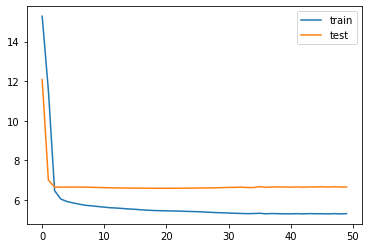

In [27]:
# Diseño de la red recurrente LSTM
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(64))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# entrenar red
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [29]:
newdf=dataComp.iloc[1:2,:]
newdf=pd.DataFrame(newdf)


In [ ]:
newdf

,NOMBRE,TIPO
DATE,,
2009-01-01,Annie,DOMESTICO MEDIO


In [30]:
newdf['TIPO'] = newdf['TIPO'].astype(str)
newdf['NOMBRE'] =newdf['NOMBRE'].astype(str)
newdf.columns

Index(['NOMBRE', 'TIPO'], dtype='object')

In [31]:
# The following code is for your newdf after training and testing on original df
# Apply ohe on newdf

cat_ohe_new = ohe.transform(newdf[categorical_cols])
#Create a Pandas DataFrame of the hot encoded column
ohe_df_new = pd.DataFrame(cat_ohe_new, columns = ohe.get_feature_names(input_features = categorical_cols))
#concat with original data and drop original columns
df_ohe_new = pd.concat([newdf, ohe_df_new], axis=1).drop(columns = categorical_cols, axis=1)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
pd.DataFrame(ohe_df_new)

,NOMBRE_Agnes,NOMBRE_Alice,NOMBRE_Anna,NOMBRE_Annie,NOMBRE_Clara,NOMBRE_Dorothy,NOMBRE_Elizabeth,NOMBRE_Elsie,NOMBRE_Esther,NOMBRE_Ethel,NOMBRE_Frances,NOMBRE_Helen,NOMBRE_Jean,NOMBRE_Julia,NOMBRE_Lillian,NOMBRE_Louise,NOMBRE_Lucy,NOMBRE_Margaret,NOMBRE_Marie,NOMBRE_Martha,NOMBRE_Mary,NOMBRE_Mildred,NOMBRE_Pauline,NOMBRE_Ruth,TIPO_DOMESTICO BAJA,TIPO_DOMESTICO MEDIO,TIPO_DOMESTICO RESIDENCIAL,TIPO_SOCIAL
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
ohe_df_new.shape

(1, 28)

In [47]:
ohe_df_new

,NOMBRE_Agnes,NOMBRE_Alice,NOMBRE_Anna,NOMBRE_Annie,NOMBRE_Clara,NOMBRE_Dorothy,NOMBRE_Elizabeth,NOMBRE_Elsie,NOMBRE_Esther,NOMBRE_Ethel,NOMBRE_Frances,NOMBRE_Helen,NOMBRE_Jean,NOMBRE_Julia,NOMBRE_Lillian,NOMBRE_Louise,NOMBRE_Lucy,NOMBRE_Margaret,NOMBRE_Marie,NOMBRE_Martha,NOMBRE_Mary,NOMBRE_Mildred,NOMBRE_Pauline,NOMBRE_Ruth,TIPO_DOMESTICO BAJA,TIPO_DOMESTICO MEDIO,TIPO_DOMESTICO RESIDENCIAL,TIPO_SOCIAL
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [46]:
newPrincipalComponents = pca.fit_transform(ohe_df_new)
newprincipalDf = pd.DataFrame(data = NewPrincipalComponents
             , columns = num_pc)

newprincipalDf=round(newprincipalDf, 2)
print(newprincipalDf)

ValueError: ignored

In [ ]:
# predict on df_ohe_new
predict = model.predict(ohe_df_new)


ValueError: ignored

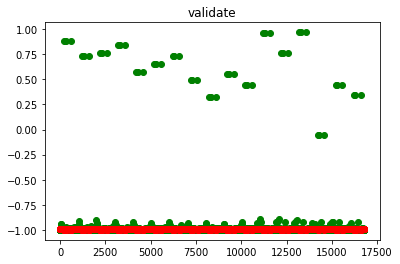

In [ ]:
results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

In [ ]:
ultimosDias = dataComp['2015-11-01':'2015-12-31']
ultimosDias

,CONSUMO
DATE,
2015-11-01,22.0
2015-11-01,17.0
2015-11-01,6.0
2015-11-01,18.0
2015-11-01,27.0
...,...
2015-12-01,11.0
2015-12-01,4.0
2015-12-01,6.0


In [ ]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test

array([[[-0.81621623, -0.6432432 , -0.92432433, ..., -0.9891892 ,
         -0.7405405 , -0.91351354]],

       [[-0.6432432 , -0.92432433, -0.96756756, ..., -0.7405405 ,
         -0.91351354, -0.97837836]],

       [[-0.92432433, -0.96756756, -0.8378378 , ..., -0.91351354,
         -0.97837836, -0.7945946 ]],

       ...,

       [[-0.7405405 , -0.7405405 , -0.77297294, ..., -0.8810811 ,
         -0.9567568 , -0.9351351 ]],

       [[-0.7405405 , -0.77297294, -0.7405405 , ..., -0.9567568 ,
         -0.9351351 , -0.81621623]],

       [[-0.77297294, -0.7405405 , -0.8378378 , ..., -0.9351351 ,
         -0.81621623, -0.5891892 ]]], dtype=float32)

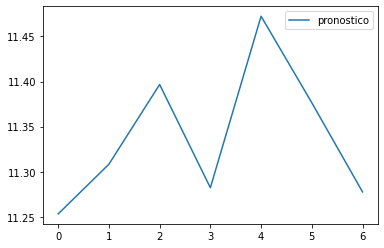

In [ ]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico.csv')

Epoch 1/100
934/934 - 15s - loss: 0.0123 - val_loss: 0.0095 - 15s/epoch - 16ms/step
Epoch 2/100
934/934 - 12s - loss: 0.0081 - val_loss: 0.0095 - 12s/epoch - 13ms/step
Epoch 3/100
934/934 - 12s - loss: 0.0082 - val_loss: 0.0102 - 12s/epoch - 13ms/step
Epoch 4/100
934/934 - 12s - loss: 0.0074 - val_loss: 0.0091 - 12s/epoch - 12ms/step
Epoch 5/100
934/934 - 12s - loss: 0.0079 - val_loss: 0.0090 - 12s/epoch - 12ms/step
Epoch 6/100
934/934 - 12s - loss: 0.0071 - val_loss: 0.0090 - 12s/epoch - 12ms/step
Epoch 7/100
934/934 - 11s - loss: 0.0070 - val_loss: 0.0088 - 11s/epoch - 12ms/step
Epoch 8/100
934/934 - 11s - loss: 0.0068 - val_loss: 0.0088 - 11s/epoch - 12ms/step
Epoch 9/100
934/934 - 11s - loss: 0.0067 - val_loss: 0.0086 - 11s/epoch - 12ms/step
Epoch 10/100
934/934 - 12s - loss: 0.0067 - val_loss: 0.0086 - 12s/epoch - 12ms/step
Epoch 11/100
934/934 - 11s - loss: 0.0067 - val_loss: 0.0085 - 11s/epoch - 12ms/step
Epoch 12/100
934/934 - 11s - loss: 0.0067 - val_loss: 0.0086 - 11s/epoch -

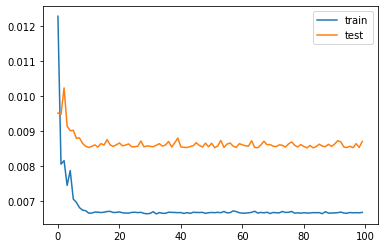

In [ ]:
# Diseño de la red recurrente LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(128))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred= model.predict(test_X)


In [ ]:
pd.DataFrame(test_y)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4003,4004,4005,4006,4007,4008,4009,4010,4011,4012,4013,4014,4015,4016,4017,4018,4019,4020,4021,4022,4023,4024,4025,4026,4027,4028,4029,4030,4031,4032,4033,4034,4035,4036,4037,4038,4039,4040,4041,4042
0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,28.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16796,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16797,16.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16798,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_pred.shape

(16800, 1)

(16800, 4043)

In [ ]:
tes

In [ ]:
mean_squared_error(test_y, y_pred, squared=False)

In [ ]:
 # serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")
 

Saved model to disk
Loaded model from disk


In [ ]:
#FUNCION PARA ESCOGER UN REGISTRO DENTRO DEL DATAFRAME PARA LAS PRUEBAS DE VALIDACION
def selectRabbit(user):
  xnew = dataComp.iloc[user , 1:999]
  return xnew


In [ ]:
#FUNCION PARA BUSCAR EL VALOR REAL DE CONSUMO DENTRO DEL DATAFRAME
def searchForReal(user):
  real= dataComp.iloc[user ,-1]
  return real

In [ ]:
user=dataComp.iloc[-1,1:]

In [ ]:
user.shape

(4043,)

In [ ]:
def prediccion(user):
    Xnew = np.array([dataComp.iloc[-1,1:]])#real es 79
    print(Xnew.shape)
    #xnew=selectRabbit(user)
    Xnew= scaler.transform(Xnew)
    Xnew = Xnew.reshape((Xnew.shape[0], 1, Xnew.shape[1]))
    print(Xnew.shape)
    pred= model.predict(Xnew)[0]
    return pred
    
pred=prediccion(83)
print('PREDICCION DE CONSUMO: ',pred)
#print('USUARIO CONSUMO REAL :  [',searchForReal(83),']')

(1, 4043)
(1, 1, 4043)


ValueError: ignored